# Toward Optimal Retrieval: Dynamically Choosing `k` in Vector-Based Search


## 📚 Introduction to Retrieval-Augmented Generation (RAG)

### What is RAG?

**Retrieval-Augmented Generation (RAG)** is a hybrid architecture that combines the strengths of **retrieval-based** systems and **generative language models**. Instead of relying solely on a language model's internal parameters to answer questions or generate content, RAG explicitly augments the generation process by retrieving relevant external knowledge.

The RAG architecture was introduced to address limitations in traditional language models, especially their tendency to **"hallucinate"** or produce incorrect information due to lack of grounding in external knowledge sources.

---

### 🔍 Why Use RAG?

Pre-trained language models (e.g., GPT, LLaMA, etc.) are trained on massive datasets but are inherently static:

- They cannot learn new knowledge after training unless fine-tuned.
- Their knowledge is limited to their training cutoff.
- They struggle with domain-specific or long-tail queries.

RAG solves these problems by:
- **Fetching real-time or up-to-date information** from external sources like documents, databases, or knowledge graphs.
- **Reducing hallucinations** by grounding responses in retrieved context.
- **Improving performance** on specialized tasks or domains without retraining the model.

---

### 🧠 How Does RAG Work?

The RAG pipeline generally consists of **three main components**:

1. **Encoder-based Retriever**
   - Given an input query, a retriever fetches the top-*k* most relevant documents from a vectorDB (e.g., FAISS, ChromaDB) using vector similarity search.
   - These documents serve as an external knowledge source.

2. **Contextual Fusion**
   - The retrieved documents are passed alongside the query into a language model (e.g., a transformer decoder) to generate an informed response.
   - This can be done by concatenating the documents and query into a single prompt.

3. **Generator**
   - A generative model (like GPT or BART) produces the final output based on the augmented input (query + retrieved knowledge).

```text
User Query → Retriever → Top-k Documents → Generator → Final Answer


## Setup -  Lets create a simple RAG Agent

### 🔧 1. Install Dependencies

In [41]:
!pip install langchain chromadb langchain-community langchain-openai tiktoken python-dotenv datasets ipywidgets rapidfuzz seaborn sentence-transformers

### 🔐 2. Set API Key

In [42]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Access the key
api_key = os.getenv("OPENAI_API_KEY")

# Set it as environment variable for OpenAI
os.environ["OPENAI_API_KEY"] = api_key

### 3. Load HotpotQA Dataset

In [43]:
from datasets import load_dataset

hotpot = load_dataset("hotpot_qa", "fullwiki")
print(hotpot)

# Use 'train' or 'validation' split
hotpot_qa_dataset = hotpot["validation"]  # or hotpot["train"]
print(len(hotpot_qa_dataset))


DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 90447
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
    test: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})
7405


### 🧠 Step 4: Create the documents from the dataset

In [44]:
from langchain_core.documents import Document

def extract_hotpot_documents(dataset):
    docs = []
    seen_passages = set()

    for example in dataset:
        titles = example["context"]["title"]
        sentence_lists = example["context"]["sentences"]

        for title, sentences in zip(titles, sentence_lists):
            content = " ".join(sentences).strip()
            key = (title, content)
            if content and key not in seen_passages:
                doc = Document(
                    page_content=content,
                    metadata={"source": title}
                )
                docs.append(doc)
                seen_passages.add(key)
    return docs

documents = extract_hotpot_documents(hotpot_qa_dataset)
print(f"Extracted {len(documents)} documents.")


Extracted 66573 documents.


### Step 5: Create embeddings and store in ChromaDB

In [45]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings()

# Reuse if it exists, or create new if not
persist_dir = "./chroma_db"

try:
    # Try loading the existing index
    vectorstore = Chroma(
        persist_directory=persist_dir,
        embedding_function=embedding_model
    )

    # Check if index is empty (optional)
    if len(vectorstore.get()['ids']) == 0:
        raise ValueError("Vectorstore loaded but is empty.")

except Exception as e:
    print("⚠️ Vectorstore not found or empty. Rebuilding it...")
    from langchain_core.documents import Document

    # Create VectorDB
    vectorstore = Chroma.from_documents(
        documents,
        embedding_model,
        persist_directory=persist_dir
    )


⚠️ Vectorstore not found or empty. Rebuilding it...


### 🤖 Step 6: Define the RAG Agent

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import Document
from typing import Dict, List


class CustomRAGAgent:
    def __init__(self, retriever, llm, prompt):
        self.retriever = retriever
        self.llm = llm
        self.prompt = prompt

    def invoke(self, inputs: Dict[str, str]) -> Dict:
        question = inputs["question"]
        docs: List[Document] = self.retriever.get_relevant_documents(question)
        summaries = "\n\n".join(doc.page_content for doc in docs)

        # Format the full prompt
        messages = self.prompt.format_messages(question=question, summaries=summaries)
        full_prompt_str = "\n\n".join([f"{msg.type.upper()}:\n{msg.content}\n" for msg in messages])

        # Get the LLM's response
        response = self.llm.invoke(messages)

        return {
            "answer": response.content,
            "source_documents": docs,
            "full_prompt": full_prompt_str
        }


def create_rag_agent(k: int):
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.3, max_tokens=8000)

    system_template = (
        "You are a Retrieval-Augmented Generation (RAG) agent. "
        "Answer only using the provided context below. "
        "Respond with concise. accurate answers. Use the least amount of words needed in your answer."
        "Context:\n{summaries}"
    )

    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template("Question: {question}")
    ])

    return CustomRAGAgent(retriever, llm, prompt)


## Simple Example

#### Lets add some custom documents  

In [ ]:
# Add our custom documents

existing_docs = vectorstore.similarity_search(
    query="irrelevant dummy text",
    k=100,  # large enough to ensure matches if any exist
    filter={"id": 111111}
)

if not existing_docs:
    print("Adding custom documents")
    yarin = Document(page_content="Yarin's favorite food is Pizza", metadata={"id": 111111, "source": 3201})
    michal = Document(page_content="Michal's favorite food is Croissant",metadata={"id": 111112, "source": 3202})
    vectorstore.add_documents([yarin, michal])
else:
    print("Custom documents already exist")

Custom documents already exist


### 🤖 5.1. Create a RAG agent with fixed 'k' (k=1) 

In [ ]:
# Create RAG agent with k = 1
rag_agent = create_rag_agent(k=1)

In [ ]:
result = rag_agent.invoke({"question": "what is Yarin's favortie food?"})
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Pizza

-------------Full prompt:-------------

SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use the least amount of words needed in your answer.Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what is Yarin's favortie food?



### What about Michal's favorite food?

In [ ]:
result = rag_agent.invoke({"question": "what is Michal's favortie food?"})
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Croissant

-------------Full prompt:-------------

SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use the least amount of words needed in your answer.Context:
Michal's favorite food is Croissant


HUMAN:
Question: what is Michal's favortie food?



### Lets see if he can answer for both of us

In [ ]:
result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"})
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Yarin's favorite food is pizza. Michal's favorite food is not provided.

-------------Full prompt:-------------
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use the least amount of words needed in your answer.Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what are Yarin's and Michal's favortie food?



### Thats too bad...

### I guess k=1 is not the best option

### What about k=2 ?

### 🤖 5.2. Create a RAG agent with fixed 'k' (k=2) 

In [ ]:
rag_agent = create_rag_agent(k=2)

result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"})
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Yarin's favorite food is Pizza; Michal's favorite food is Croissant.

-------------Full prompt:-------------
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use the least amount of words needed in your answer.Context:
Yarin's favorite food is Pizza

Michal's favorite food is Croissant


HUMAN:
Question: what are Yarin's and Michal's favortie food?



# ❗ Problem - Limitations of Static `k` in Vector Similarity Search

## Background

In Retrieval-Augmented Generation (RAG) and other retrieval-based systems, **vector similarity search** is a key operation. Given a query, the system retrieves the top-*k* most similar documents from a vector database using semantic embeddings and similarity metrics (e.g., cosine similarity or dot product).

The parameter **`k`** represents the number of documents to retrieve per query. In most RAG implementations, `k` is set to a **fixed value** (e.g., `k=3` or `k=5`) for all inputs.

While simple and easy to implement, **using a static value of `k` across all inputs introduces several problems** that can negatively impact retrieval relevance, model performance, and computational efficiency.

---

## 🔍 The Core Problem: One-Size-Does-Not-Fit-All

Different user queries or prompts have different levels of complexity, ambiguity, and knowledge requirements. However, a static `k` assumes that **every query benefits equally from the same number of retrieved documents** — which is often not true.

---

## 🔥 Why a Fixed `k` is Suboptimal

### 1. **Under-retrieval (k too small)**
- Important context may be **missed**, especially for complex or vague queries.
- Language model generates **incomplete or hallucinated** responses due to lack of sufficient information.
- Example: A legal or medical question might require 10+ documents to cover relevant information.

### 2. **Over-retrieval (k too large)**
- Irrelevant or noisy documents may dilute the useful context.
- More documents → longer input prompt → higher **token costs** in LLMs.
- May confuse the model, especially when irrelevant docs are included.
- Wastes compute, memory, and latency for simple, narrow queries.

### 3. **No Adaptivity to Query Entropy or Difficulty**
- Not all queries are created equal:
  - Some are **simple and factoid-like** ("What is the capital of Italy?")
  - Others are **ambiguous, multi-faceted, or domain-specific**
- Fixed `k` ignores this variability, leading to suboptimal results in either direction.

---

## 🎯 Research Objective

The goal of this research is to **dynamically determine the optimal value of `k` per query**, based on characteristics of the input or the retrieval results — such as:

- Query entropy or uncertainty
- Query length and type
- Similarity distribution of top retrieved documents
- Historical performance metrics

By intelligently adjusting `k`, we aim to improve:

- Retrieval relevance and precision
- LLM answer quality
- Efficiency and cost-effectiveness of the system

In the next sections, we will explore strategies, algorithms, and evaluation methods for achieving this dynamic retrieval objective.



## 🧪 RAG Evaluation

### 🔍 Evaluation Setup
- **Corpus**: A subset of Wikipedia documents (`rag-mini-wikipedia`, `text-corpus` split).
- **Questions**: Sourced from the `question-answer` split of the same dataset.
- **Model**: `gpt-4o-mini` used via LangChain's `ChatOpenAI`.
- **Retriever**: ChromaDB vectorstore with top-k document retrieval (`k = 1`).
- **Goal**: Compare generated answers to ground-truth answers using fuzzy matching for leniency.

### 🧠 Accuracy Metric
- We use **cosine similarity**
- A prediction is considered correct if its cosine similarity score with the ground truth exceeds a given threshold (e.g. `>= 0.8`).

---


In [ ]:
import numpy as np


def get_embedding(text: str) -> list[float]:
    """Get embedding"""
    response = embedding_model.embed_query(text)
    return response

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return float(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

# Initialize the ChatOpenAI once, ideally outside the function for efficiency
chat_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def llm_string_similarity(str1: str, str2: str, ground_truth: str) -> int:
    """
    Use LangChain's ChatOpenAI model to judge if str2 is similar enough to ground_truth and str1.
    Returns 1 if similar, else 0.
    """

    prompt = (
        f"Given the question:\n\"{str1}\"\n"
        f"and the predicted answer:\n\"{str2}\"\n"
        f"and the ground truth answer:\n\"{ground_truth}\"\n"
        f"Answer only with 1 if the predicted answer is semantically and syntactically similar enough to the ground truth, "
        f"otherwise answer with 0."
    )

    response = chat_llm([HumanMessage(content=prompt)])

    answer = response.content.strip()
    return 1 if answer == "1" else 0


In [ ]:
import random
import textwrap
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def evaluate_rag_agent_parallel(
    dataset,
    k: int = 3,
    n_questions: int = 10,
    threshold: int = 1,  # Only accept 1 as similar
    seed: int = 42,
    max_workers: int = 8
):
    total_available = len(dataset["question"])
    indices = list(range(total_available))
    random.Random(seed).shuffle(indices)
    selected_indices = indices[:n_questions]

    questions = [dataset["question"][i] for i in selected_indices]
    answers = [dataset["answer"][i] for i in selected_indices]

    rag_agent = create_rag_agent(k=k)

    results = []
    correct = 0
    evaluated = 0

    print(f"\n🔍 Evaluating RAG Agent with k={k}, n_questions={n_questions}, threshold={threshold}, seed={seed}, threads={max_workers}\n")

    def evaluate_single(idx, question, ground_truth):
        try:
            input_data = {"question": question}
            result = rag_agent.invoke(input_data)
            prediction = result["answer"]
            source_docs = result.get("source_documents", [])
            full_prompt = result.get("full_prompt") 
        except Exception as e:
            return {
                "index": idx,
                "question": question,
                "ground_truth": ground_truth,
                "prediction": None,
                "similar": None,
                "status": "error",
                "error": str(e),
                "retrieved_docs": [],
                "full_prompt": None
            }

        try:
            # LLM similarity returns 0 or 1
            similar = llm_string_similarity(question, prediction, ground_truth)
        except Exception as e:
            return {
                "index": idx,
                "question": question,
                "ground_truth": ground_truth,
                "prediction": prediction,
                "similar": None,
                "status": "similarity_error",
                "error": str(e),
                "retrieved_docs": [],
                "full_prompt": full_prompt
            }

        status = "correct" if similar == 1 else "incorrect"
        return {
            "index": idx,
            "question": question,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "similar": similar,
            "status": status,
            "error": None,
            "retrieved_docs": [
                {"source": doc.metadata.get("source", None), "content": doc.page_content} for doc in source_docs
            ],
            "full_prompt": full_prompt
        }

    def print_wrapped(text, max_width=100):
        lines = textwrap.wrap(text, width=max_width)
        for line in lines:
            print(line)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(evaluate_single, idx, q, a)
            for idx, (q, a) in enumerate(zip(questions, answers))
        ]

        for future in tqdm(as_completed(futures), total=n_questions, desc=f"Evaluating k={k}"):
            log = future.result()
            results.append(log)
            if log["status"] == "correct":
                correct += 1
            if log["status"] in {"correct", "incorrect"}:
                evaluated += 1

    results.sort(key=lambda x: x["index"])

    for log in results:
        print(f"\n[{log['index']}] (k={k}) {'✅' if log['status'] == 'correct' else '❌'} {log['status'].upper()}")
        print(f"Q: {log['question']}")
        print(f"Predicted: {log['prediction']}")
        print(f"Ground Truth: {log['ground_truth']}")
        if log["similar"] is not None:
            print(f"Similarity (0 or 1): {log['similar']}")
        else:
            print("Similarity: N/A")

        if log["full_prompt"]:
            print("📨 Full Prompt:")
            print_wrapped(log["full_prompt"])
        print("-" * 60)

        if log["status"] not in {"correct", "incorrect"}:
            print(f"⚠️ Error: {log['error']}")

    accuracy = correct / evaluated if evaluated > 0 else 0.0
    print(f"\n🎯 Final Accuracy on {evaluated} evaluated questions (k={k}): {accuracy:.2%}")

    return {
        "k": k,
        "n_questions": n_questions,
        "accuracy": accuracy,
        "evaluated": evaluated,
        "correct": correct,
        "logs": results,
        "seed": seed,
        "selected_indices": selected_indices
    }


In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_comparison(results: list):
    """
    Plot accuracy comparison from multiple evaluation runs.

    Args:
        results: List of dicts returned from evaluate_rag_agent().
    """
    ks = [res["k"] for res in results]
    accuracies = [res["accuracy"] for res in results]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, accuracies, marker='o', linestyle='--', label='Accuracy')

    for k, acc in zip(ks, accuracies):
        plt.text(k, acc + 0.02, f"{acc:.2%}", ha='center')

    plt.title("📊 RAG Accuracy vs. Number of Retrieved Documents (k)")
    plt.xlabel("k (Top-K Retrieved Documents)")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(ks)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
results = []
seed = random.randint(0, 10_000_000)
n_questions = 10

for k in range(1,11):
    res = evaluate_rag_agent_parallel(
        dataset=hotpot_qa_dataset,
        k=k,
        n_questions=n_questions,
        threshold=0.8,
        seed=seed,
        max_workers=10
    )
    results.append(res)



🔍 Evaluating RAG Agent with k=1, n_questions=10, threshold=0.8, seed=533344, threads=10



Evaluating k=1: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]



[0] (k=1) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=1) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=1) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=1) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=2: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]



[0] (k=2) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=2) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=2) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=2) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=3: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]



[0] (k=3) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=3) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=3) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=3) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=4: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s]



[0] (k=4) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=4) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=4) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=4) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=5: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s]



[0] (k=5) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=5) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=5) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=5) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=6: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s]



[0] (k=6) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=6) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=6) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=6) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=7: 100%|██████████| 10/10 [00:00<00:00, 22.45it/s]



[0] (k=7) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=7) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=7) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=7) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=8: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s]



[0] (k=8) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=8) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=8) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=8) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=9: 100%|██████████| 10/10 [00:00<00:00, 18.44it/s]



[0] (k=9) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=9) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=9) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=9) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: January 28

Evaluating k=10: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s]


[0] (k=10) ❌ ERROR
Q: Who was hung for assisting the attempted surrender of a defector from the American Continental Army to the British Army?
Predicted: None
Ground Truth: John André
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=10) ❌ ERROR
Q: Michelle Lewis has written songs for which "Lizzie McGuire" actress? 
Predicted: None
Ground Truth: Hilary Duff
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=10) ❌ ERROR
Q: When did the English local newspaper, featuring the sculpture and war memorial in the Forbury gardens, change names?
Predicted: None
Ground Truth: 2009
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=10) ❌ ERROR
Q: The person "Planet Earth Rock and Roll Orchestra" was the final solo album for died on what date?
Predicted: None
Ground Truth: Januar

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_21091/2433052100.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


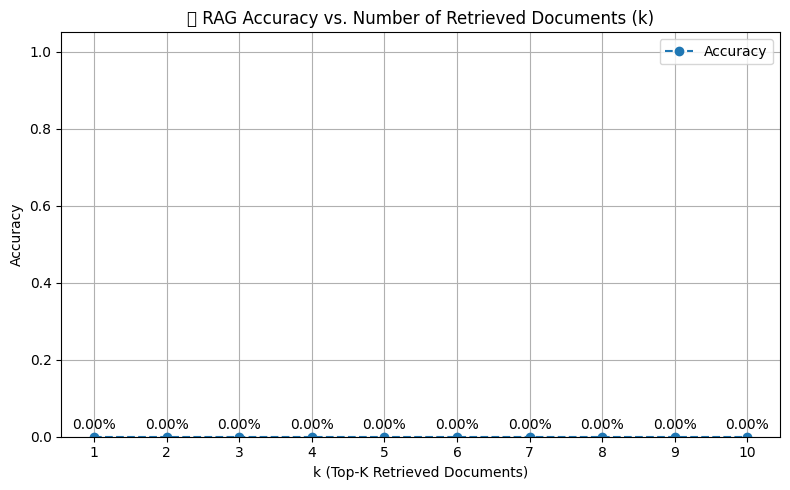

In [ ]:
plot_accuracy_comparison(results)

In [ ]:
def evaluate_multiple_k(dataset, k_values, n_questions=10, threshold=0.75, seed=42):
    all_results = {}

    for k in k_values:
        print(f"\n=== Evaluating for k = {k} ===\n")
        results = evaluate_rag_agent_parallel(
            dataset,
            k=k,
            n_questions=n_questions,
            threshold=threshold,
            seed=seed,
        )
        all_results[k] = results["logs"]  # store per-question results
    return all_results



import pandas as pd

def build_correctness_matrix(results_by_k):
    # results_by_k: {k: [logs]}
    matrix = []

    for k, logs in results_by_k.items():
        for log in logs:
            matrix.append({
                "question_idx": log["index"],
                "k": k,
                "status": log["status"]
            })

    df = pd.DataFrame(matrix)
    df["correct"] = df["status"] == "correct"
    return df


import seaborn as sns
import matplotlib.pyplot as plt

def plot_correct_k_heatmap(correctness_df):
    pivot = correctness_df.pivot(index="question_idx", columns="k", values="correct")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap="Greens", cbar=True, annot=True, fmt=".0f")
    plt.title("✅ Correct Answers per Question across Different k Values")
    plt.xlabel("k")
    plt.ylabel("Question Index")
    plt.tight_layout()
    plt.show()



k_values = list(range(1, 11))
results_by_k = evaluate_multiple_k(hotpot_qa_dataset, k_values=k_values, n_questions=20, threshold=0.8)




=== Evaluating for k = 1 ===


🔍 Evaluating RAG Agent with k=1, n_questions=20, threshold=0.8, seed=42, threads=8



Evaluating k=1: 100%|██████████| 20/20 [00:00<00:00, 23.20it/s]



[0] (k=1) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=1) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=1) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=1) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=2: 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]



[0] (k=2) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=2) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=2) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=2) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=3: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]



[0] (k=3) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=3) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=3) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=3) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=4: 100%|██████████| 20/20 [00:01<00:00, 18.86it/s]



[0] (k=4) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=4) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=4) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=4) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=5: 100%|██████████| 20/20 [00:01<00:00, 19.94it/s]



[0] (k=5) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=5) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=5) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=5) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=6: 100%|██████████| 20/20 [00:01<00:00, 14.38it/s]



[0] (k=6) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=6) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=6) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=6) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=7: 100%|██████████| 20/20 [00:01<00:00, 18.23it/s]



[0] (k=7) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=7) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=7) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=7) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=8: 100%|██████████| 20/20 [00:00<00:00, 21.75it/s]



[0] (k=8) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=8) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=8) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=8) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=9: 100%|██████████| 20/20 [00:00<00:00, 21.49it/s]



[0] (k=9) ❌ ERROR
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Predicted: None
Ground Truth: flotilla
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[1] (k=9) ❌ ERROR
Q: When did the park at which Tivolis Koncertsal is located open?
Predicted: None
Ground Truth: 15 August 1843
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[2] (k=9) ❌ ERROR
Q: What is the shared country of ancestry between Art Laboe and Scout Tufankjian?
Predicted: None
Ground Truth: Armenian
Similarity: N/A
------------------------------------------------------------
⚠️ Error: unable to open database file

[3] (k=9) ❌ ERROR
Q: The school in which the Wilmslow Show is held is designated as what?
Predicted: None
Ground Truth: Centre of Excellence
Similarity: N/A
-----------------------------

Evaluating k=10:  60%|██████    | 12/20 [00:00<00:00, 18.27it/s]


KeyboardInterrupt: 

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_21091/460336443.py:47: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


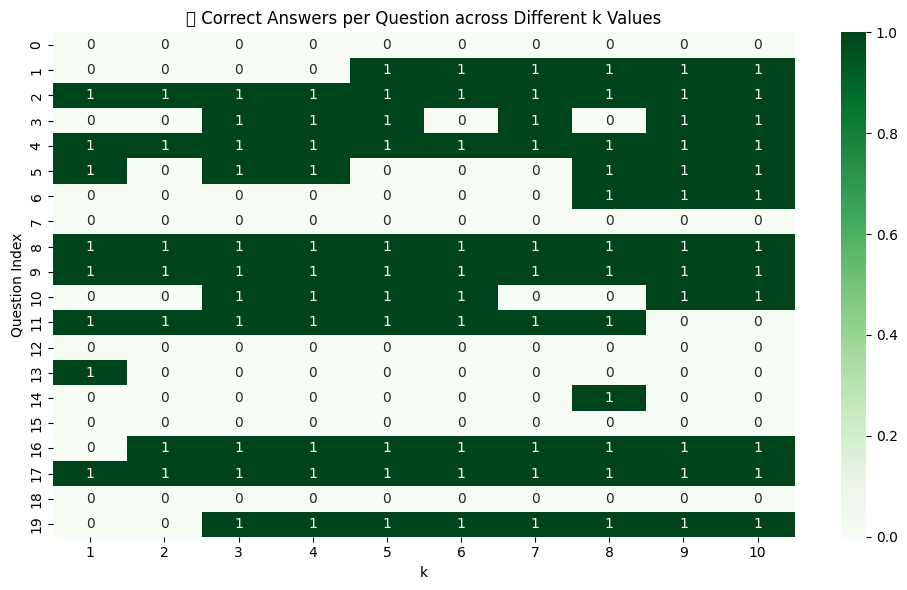

In [ ]:
correctness_df = build_correctness_matrix(results_by_k)
plot_correct_k_heatmap(correctness_df)

In [ ]:
import re
import string

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [ ]:
from collections import Counter

def compute_f1(a_pred, a_gold):
    pred_tokens = normalize_answer(a_pred).split()
    gold_tokens = normalize_answer(a_gold).split()
    common = Counter(pred_tokens) & Counter(gold_tokens)
    num_same = sum(common.values())

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return int(pred_tokens == gold_tokens)

    if num_same == 0:
        return 0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1


In [ ]:
import matplotlib.pyplot as plt

def plot_f1_scores_by_k(results: list):
    """
    Plot histogram of F1 scores per `k` value.

    Args:
        results: List of evaluation results from `evaluate_rag_agent`, each must contain 'k' and 'logs'.
    """
    plt.figure(figsize=(12, 6))

    for result in results:
        k = result["k"]
        logs = result["logs"]

        f1_scores = []
        for log in logs:
            pred = log.get("prediction")
            truth = log.get("ground_truth")
            if not pred or not truth:
                continue
            f1 = compute_f1(pred, truth)
            f1_scores.append(f1)

        if not f1_scores:
            continue

        mean_f1 = sum(f1_scores) / len(f1_scores)
        plt.hist(
            f1_scores,
            bins=20,
            alpha=0.6,
            edgecolor='black',
            label=f"k={k} (avg F1={mean_f1:.2%})"
        )

    plt.title("F1 Score Distribution by k")
    plt.xlabel("F1 Score")
    plt.ylabel("Count of Questions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


{'k': 1, 'n_questions': 10, 'accuracy': 0.5, 'evaluated': 10, 'correct': 5, 'logs': [{'index': 9, 'question': 'Bridgewater Triangle is an area where the phenomenon associated with what type of tradition has been seen?', 'ground_truth': 'Native American', 'prediction': 'Paranormal phenomena.', 'score': 0.2, 'status': 'incorrect', 'error': None, 'retrieved_docs': [{'source': 'Bridgewater Triangle', 'content': 'The Bridgewater Triangle refers to an area of about 200 mi2 within southeastern Massachusetts in the United States, claimed to be a site of alleged paranormal phenomena, ranging from UFOs to poltergeists, orbs, balls of fire and other spectral phenomena, various bigfoot-like sightings, giant snakes and "thunderbirds."'}], 'full_prompt': 'SYSTEM:\nYou are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use the least amount of words needed in your answer.Context:\nThe Bridgewater Triangle refers to an

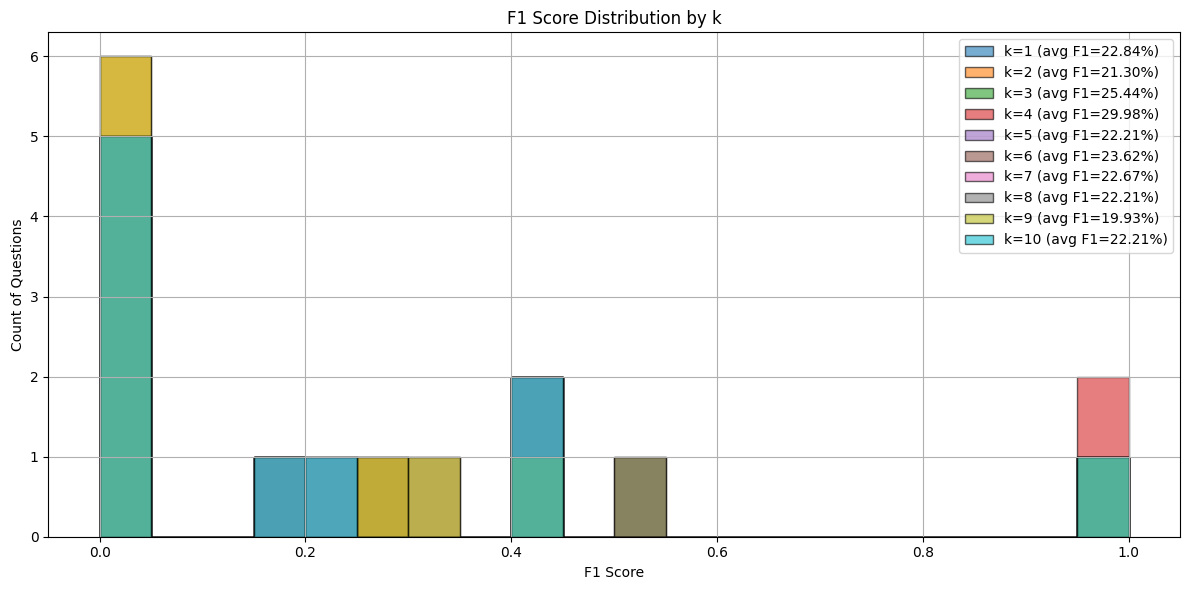

In [ ]:
print(results[0])
plot_f1_scores_by_k(results)

Nice! the rag agent knows what we like to eat

But it means we need to manually change the value of 'k' which is not ideal...


# 🧪 Approaches to Dynamically Determine `k` in Vector Similarity Search

Choosing the right number of documents (`k`) to retrieve for a given query is crucial for balancing relevance, efficiency, and downstream model performance in RAG systems.

Here we explore three statistically-motivated techniques for determining `k` dynamically based on the **distribution of similarity scores** between the query and candidate documents.

---

## 1. Benjamini–Hochberg Procedure (False Discovery Rate Control)

### 🔍 Overview
The **Benjamini–Hochberg (BH) procedure** is a statistical method for **controlling the False Discovery Rate (FDR)** — the expected proportion of false positives among the selected items. It is typically used in multiple hypothesis testing scenarios.

In the context of vector similarity search:
- Each document can be treated as a "hypothesis" (i.e., "Is this document relevant?").
- We compute **p-values** (or a proxy derived from similarity scores) for each document.
- BH controls the expected rate of false positives among the selected top-*k* documents.

### ⚙️ How it works
1. Convert similarity scores into pseudo p-values (e.g., via ranking or null distribution assumptions).
2. Sort these p-values in ascending order: $( p_1, p_2, ..., p_n )$
3. For each p-value, check:
$
p_i \leq \frac{i}{n} \cdot \alpha
$


   where $\alpha \$ is the desired FDR (e.g., 0.05).
4. Select the **largest `i`** that satisfies the inequality — set `k = i`.

### ✅ Pros
- More power than conservative tests like Bonferroni.
- Controls false discovery rather than per-test error.
- Adapts naturally to the number and quality of candidate documents.

---

## 2. Bonferroni Correction (Family-Wise Error Rate Control)

### 🔍 Overview
The **Bonferroni correction** is a conservative method to control the **Family-Wise Error Rate (FWER)** — the probability of making **any** false discovery.

It is stricter than BH and is often used when **false positives must be avoided at all costs**.

### ⚙️ How it works
1. Convert similarity scores into pseudo p-values.
2. Adjust the threshold using:
   $
   \alpha' = \frac{\alpha}{n}
   $
   where $ n $ is the total number of documents and $\alpha$ is the desired overall error rate (e.g., 0.05).
3. Select all documents with $p_i \leq \alpha'$
4. Set `k` as the number of documents that meet the criterion.

### ⚠️ Caveats
- Very conservative: often results in **low `k`** or even `k=0`, especially when many candidates are noisy or weakly similar.
- Better suited for high-stakes applications where **false positives are expensive**.

---

## 3. Higher Criticism Thresholding

### 🔍 Overview
**Higher Criticism (HC)** is a powerful method for detecting **sparse and weak signals** in large-scale testing problems. It is especially effective when:
- Only a small fraction of documents are truly relevant.
- Their similarity scores are only **slightly stronger than noise**.

Originally proposed by Donoho & Jin (2008), HC finds an **optimal threshold** by balancing signal detection and noise suppression.

📄 [PNAS Article](https://www.pnas.org/doi/abs/10.1073/pnas.0807471105)

### ⚙️ How it works
1. Convert similarity scores into z-scores or p-values under a null model.
2. Compute the **Higher Criticism statistic** for each ordered p-value:
   $
   HC(i) = \frac{\sqrt{n} \left( \frac{i}{n} - p_i \right)}{\sqrt{p_i (1 - p_i)}}
   $
3. Find the **index `i` with the maximum HC value** → this index indicates the optimal threshold.
4. Set `k = i`, selecting the top-`k` documents as relevant.

### 🚀 Advantages
- Adaptive to sparse signal settings.
- Theoretically powerful under weak signal conditions.
- Can outperform both BH and Bonferroni when only a few strong matches exist.

---

## 📊 Summary of Methods

| Method                    | Controls           | Conservative? | Adaptive? | Best Use Case                                  |
|--------------------------|--------------------|---------------|-----------|------------------------------------------------|
| Benjamini-Hochberg (BH)  | False Discovery Rate (FDR) | ❌ No         | ✅ Yes    | General-purpose; balances false positives      |
| Bonferroni Correction     | Family-Wise Error Rate (FWER) | ✅ Yes        | ❌ No     | High-stakes tasks; requires strict precision   |
| Higher Criticism (HC)    | Sparse Signal Detection | ⚠ Depends     | ✅ Yes    | Sparse, noisy data; detecting weak signals     |

---



In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load embedding model
model = embedding_model

# Your RAG corpus (use real preprocessed passages)
rag_corpus = documents

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity

def generate_null_distribution(random_queries, corpus, model, num_pairs=10000):
    num_pairs = 1000
    print(f"Generating null distribution with {num_pairs} random query-doc pairs...")
    null_similarities = []

    for _ in tqdm(range(num_pairs)):
        q = random.choice(random_queries)
        d = random.choice(corpus)

        q_embed = model.embed_query(q)
        d_embed = model.embed_query(d.page_content)

        sim = cosine_similarity([q_embed], [d_embed])[0][0] # cosine similarity
        null_similarities.append(sim)

    return np.array(null_similarities)

#Random unrelated queries
random_queries = [
    # Tech & gadgets
    "How do I reset my password?",
    "What is two-factor authentication?",
    "Best budget laptop for students?",
    "How do I clear my browser cache?",
    "Why is my phone battery draining fast?",
    "How can I speed up an old PC?",
    "What is cloud computing in simple terms?",
    "How do I take a screenshot on Windows?",
    "Is it safe to jailbreak an iPhone?",
    "What is the difference between 4G and 5G?",

    # Weather & environment
    "What is the weather like in July?",
    "Why does it rain more in spring?",
    "How are hurricanes named?",
    "What causes a rainbow?",
    "What is the El Niño effect?",
    "How do solar eclipses occur?",
    "Tips for preparing for a heatwave?",
    "What is the pollen count today?",
    "Why do leaves change color in autumn?",
    "How does acid rain form?",

    # Language & learning
    "Tips for learning Japanese online",
    "How long to master Mandarin?",
    "Best apps for studying French verbs?",
    "What is the CEFR language scale?",
    "How do I improve my vocabulary fast?",
    "Difference between affect and effect?",
    "What are common TOEFL essay topics?",
    "Is Duolingo good for beginners?",
    "How to roll Spanish R’s?",
    "Ways to practice sign language at home?",

    # Health & wellness
    "What are the symptoms of flu?",
    "How much water should I drink daily?",
    "What is intermittent fasting?",
    "How to reduce screen time headaches?",
    "Is coffee bad for anxiety?",
    "Best stretches for lower-back pain?",
    "What is a healthy resting heart rate?",
    "How do vaccines work?",
    "Tips to improve sleep quality?",
    "Why are trans fats harmful?",

    # Cooking & food
    "How to cook rice perfectly?",
    "What is the difference between baking soda and baking powder?",
    "Easy vegetarian dinner ideas?",
    "How to make sourdough starter?",
    "Why does chocolate seize?",
    "How do you temper eggs?",
    "Substitutes for buttermilk in baking?",
    "What is the Maillard reaction?",
    "How to store fresh herbs longer?",
    "Is air-frying healthier than deep-frying?",

    # Finance & careers
    "What is compound interest?",
    "How do I start investing with little money?",
    "Difference between ETF and mutual fund?",
    "How to negotiate a salary offer?",
    "What is a 401(k) rollover?",
    "Tips for writing a good résumé?",
    "How does cryptocurrency mining work?",
    "What is an emergency fund?",
    "How to build credit from scratch?",
    "What is the gig economy?",

    # Travel & culture
    "Do I need a visa for Japan?",
    "Best time to visit Iceland for Northern Lights?",
    "What is the safest seat on a plane?",
    "How to avoid jet lag?",
    "Top attractions in Barcelona?",
    "How do Eurail passes work?",
    "What is hostel etiquette?",
    "How to learn basic phrases before traveling?",
    "Can you drink tap water in Rome?",
    "What is cultural appropriation?",

    # Sports & hobbies
    "Basic rules of cricket?",
    "How long is a marathon?",
    "What is offside in soccer?",
    "How do golf handicaps work?",
    "Beginner tips for rock climbing?",
    "What size snowboard should I get?",
    "How to train for a 5K?",
    "What is blitz chess?",
    "Best budget DSLR for photography?",
    "What is the difference between acrylic and oil paint?",

    # DIY & home
    "How to unclog a sink naturally?",
    "What is the best paint for bathrooms?",
    "How do I change a flat tire?",
    "Steps to build a raised garden bed?",
    "How to install a dimmer switch?",
    "Why is my smoke detector beeping?",
    "How do I propagate succulents?",
    "What is sustainable fashion?",
    "How to start composting at home?",
    "Easy way to patch drywall holes?",

    # Pop culture & misc
    "Who won the latest Oscars?",
    "What is the Marvel multiverse?",
    "How does streaming royalty payout work?",
    "What is K-pop?",
    "Why did vinyl records make a comeback?",
    "What is the plot of 'Dune'?",
    "How do podcasts make money?",
    "What is a meme stock?",
    "What is retrograde Mercury?",
    "What does NFT stand for?"
]


# Generate the null distribution
null_distribution = generate_null_distribution(random_queries, rag_corpus, model, num_pairs=10000)

# Save for reuse
# np.save("null_distribution.npy", null_distribution)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
from tqdm import tqdm

def _one_pair(random_queries, corpus, model, _):
    """Worker: sample one (q, d) and return their cosine sim."""
    q = random.choice(random_queries)
    d = random.choice(corpus)
    q_embed = model.embed_query(q)
    d_embed = model.embed_query(d.page_content)
    return cosine_similarity([q_embed], [d_embed])[0, 0]

def generate_null_distribution(random_queries, corpus, model,
                               num_pairs=10000,  # bigger now
                               max_workers=20):     # adapt to your CPU
    print(f"Generating {num_pairs:,} pairs with {max_workers} threads…")
    
    sims = np.empty(num_pairs, dtype=np.float32)
    worker = partial(_one_pair, random_queries, corpus, model)

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        # Submit all jobs up front for maximal overlap
        futures = [pool.submit(worker, i) for i in range(num_pairs)]
        for i, fut in enumerate(tqdm(as_completed(futures), total=num_pairs)):
            sims[i] = fut.result()

    return sims


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
from sklearn.metrics.pairwise import cosine_similarity   # still used for the cos
import numpy as np
import random
from tqdm import tqdm

def _angular_similarity(q_vec, d_vec):
    """1 – (angle / π); identical vectors → 1.0   orthogonal → 0.5   opposite → 0.0"""
    cos = cosine_similarity([q_vec], [d_vec])[0, 0]          # fast BLAS call
    angle = np.arccos(np.clip(cos, -1.0, 1.0))               # radians, [0, π]
    return 1.0 - angle / np.pi                               # rescale to [0,1]

def _one_pair(random_queries, corpus, model, _):
    q = random.choice(random_queries)
    d = random.choice(corpus)
    q_embed = model.embed_query(q)
    d_embed = model.embed_query(d.page_content)
    return _angular_similarity(q_embed, d_embed)

def generate_null_distribution(random_queries, corpus, model,
                               num_pairs=10_000,
                               max_workers=20):
    print(f"Generating {num_pairs:,} angular-sim pairs with {max_workers} threads…")

    sims = np.empty(num_pairs, dtype=np.float32)
    worker = partial(_one_pair, random_queries, corpus, model)

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        futures = [pool.submit(worker, i) for i in range(num_pairs)]
        for i, fut in enumerate(tqdm(as_completed(futures), total=num_pairs)):
            sims[i] = fut.result()

    return sims


In [ ]:
null_distribution = generate_null_distribution(random_queries, rag_corpus, model, num_pairs=10000)
np.save("null_distribution_angular.npy", null_distribution)

In [ ]:
def bonferroni_thresholding(similarities, null_distribution, alpha=0.05):
    """
    Apply Bonferroni correction to dynamically select top-k documents.
    """
    m = len(similarities)
    p_values = np.array([
        np.mean(null_distribution >= s) for s in similarities
    ])
    print(p_values)
    threshold = alpha / m
    print(f'threshold: {threshold}')
    selected_indices = np.where(p_values <= threshold)[0].tolist()
    return selected_indices, p_values

In [ ]:
# Example user query
query = "Tell me about Celsius?"
query_embedding = model.embed_query(query)

# Compute similarities to all documents in corpus
doc_embeddings = [model.embed_query(doc.page_content) for doc in rag_corpus[:150]] #todo remove :150
doc_embeddings = np.array(doc_embeddings)

# make it a NumPy 1-D array
query_embedding = np.asarray(model.embed_query(query))

# 2-D:  (n_docs , dim)
doc_embeddings = np.asarray(doc_embeddings)  

# cosine similarities  (shape = [n_docs])
cos_sim = cosine_similarity(doc_embeddings, query_embedding[None, :]).ravel()

# angular similarities  ∈ [0,1]
similarities = 1.0 - np.arccos(np.clip(cos_sim, -1.0, 1.0)) / np.pi


In [ ]:
def bonferroni_thresholding_1(similarities, null_distribution, alpha=0.05):
    """
    Compute smoothed p-values and apply Bonferroni correction.
    Laplace smoothing: p = (k + 1) / (N + 1)
    -----------------------------------------------------------
    similarities      : 1-D array-like of query-doc scores
    null_distribution : 1-D array-like of random-pair scores
    alpha             : family-wise error rate (default 0.05)
    """
    N = len(null_distribution)            # null sample size
    m = len(similarities)                 # number of docs (tests)

    # ------- smoothed p-values (vectorised) -------------------
    # For each s, count how many null scores are >= s  → k
    k = (null_distribution[:, None] >= similarities).sum(axis=0)
    p_values = (k + 1) / (N + 1)          # Laplace: add-one to k and N

    print("p-values:", p_values)

    # ------- Bonferroni threshold -----------------------------
    threshold = alpha / m
    print(f"threshold: {threshold:.6g}")

    selected_indices = np.where(p_values <= threshold)[0].tolist()
    return selected_indices, p_values

In [ ]:

# Apply Bonferroni thresholding
selected_indices, p_vals = bonferroni_thresholding_1(similarities, null_distribution, alpha=0.05)

# Display selected results
print(f"\nQuery: {query}\n")
print(f"Selected top-{len(selected_indices)} documents using Bonferroni correction:")
for idx in selected_indices:
    print(f"[Score: {similarities[idx]:.4f} | p = {p_vals[idx]}] → {rag_corpus[idx]}")